In [1]:
import pystan
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Likelihood and Priors
We can think of our model as having three components:
* Long-term trend
* Seasonal variation
* Noise

The likelihood function for the average CO2 level at any day can be modeled by:
${CO_2} \sim \text{Normal}({\mu}, {\sigma})$,
where $\mu$ is given by the long-term trend and seasonal variation, and $\sigma$ is the noise.

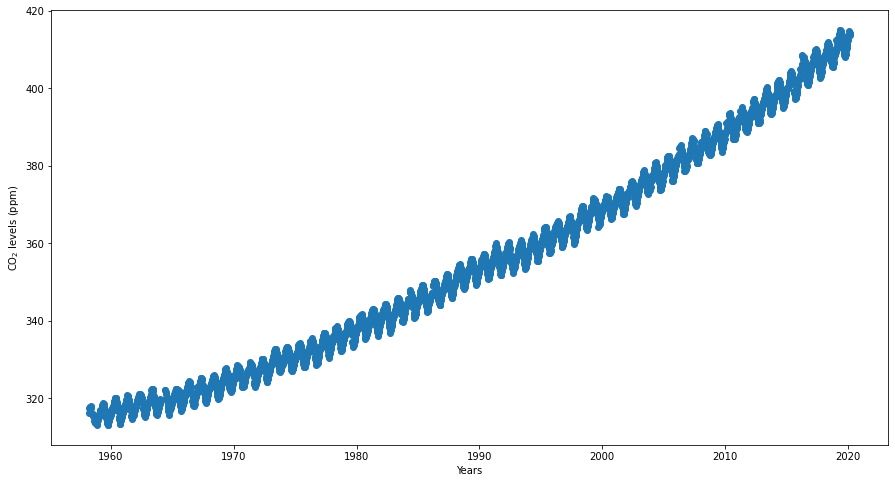

In [4]:
'''
Visualizing the data
'''

df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/CS146 Final.csv")
df.head(10)
df['Date'] = pd.to_datetime(df['Date'])

date = df['Date']
CO2 = df['CO2 ppm']

plt.figure(figsize=(15,8))
plt.scatter(date,CO2)
plt.xlabel("Years")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

In [5]:
from datetime import datetime

# Transforming the date into number of days since the first measurement
days = []
for i in range(len(date)):
  time_elapsed = date[i]-date[0]
  days.append(time_elapsed.days)

print(days)

# Assigning this to a new column in the dataframe
df['Days'] = days

[0, 7, 14, 21, 28, 35, 49, 56, 98, 105, 112, 119, 126, 133, 140, 154, 161, 224, 231, 238, 245, 252, 259, 266, 273, 280, 287, 294, 301, 308, 322, 329, 336, 343, 357, 364, 371, 378, 385, 392, 399, 406, 413, 420, 434, 441, 448, 455, 462, 469, 476, 483, 490, 497, 511, 518, 525, 532, 539, 546, 553, 560, 567, 574, 581, 588, 595, 602, 609, 616, 623, 630, 637, 644, 651, 658, 665, 672, 679, 686, 693, 700, 707, 714, 721, 728, 735, 742, 749, 756, 763, 770, 777, 784, 791, 798, 805, 812, 819, 826, 833, 840, 847, 854, 861, 868, 875, 882, 889, 896, 903, 910, 917, 924, 931, 938, 945, 952, 959, 966, 973, 980, 987, 994, 1001, 1008, 1015, 1022, 1029, 1036, 1043, 1050, 1057, 1064, 1071, 1078, 1085, 1092, 1099, 1106, 1113, 1120, 1127, 1134, 1141, 1148, 1155, 1162, 1169, 1176, 1183, 1190, 1197, 1204, 1211, 1218, 1225, 1232, 1239, 1246, 1253, 1260, 1267, 1274, 1281, 1288, 1295, 1302, 1309, 1316, 1323, 1330, 1337, 1344, 1351, 1358, 1365, 1372, 1379, 1386, 1393, 1400, 1407, 1414, 1421, 1428, 1435, 1442, 1449, 

## *Long-term Trend*
Model 1: $C_0+C_1*t+C_2*t^2$

Where:

$C_0$ ~ $Normal(310,4)$ 

$C_1$ ~ $Normal(0,0.1)$ 

$C_2$ ~ $Normal(0,0.1)$

In [0]:
stan_data_quad = {
    "n_data" : len(df),
    "time" : df['Days'],
    "ppms" : df['CO2 ppm'],
}

In [0]:
'''
Model 1
'''

quad_code = """
data {
    int<lower=0> n_data; // data size
    real<lower=0> time[n_data]; // days from first measurement
    real ppms[n_data]; // observed level of CO2 for each day
}

parameters {
    real<lower=0> C_0; // baseline constant
    real<lower=0> C_1; // linear constant
    real<lower=0> C_2; // quadratic constant
    real<lower=0> sigma; // noise
}


model {
 
    // Priors
    C_0 ~ normal(310, 4);
    C_1 ~ normal(0, 0.1);
    C_2 ~ normal(0, 0.1);
    sigma ~ gamma(3, 0.5);

    // Likelihood
    for (i in 1:n_data) {
        ppms[i] ~ normal(C_0+C_1*time[i]+C_2*time[i]^2, sigma); 
    }
}

"""

In [0]:
quad_model = pystan.StanModel(model_code=quad_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d7a3450a1e38badb02837e69e51c8d1 NOW.


In [0]:
quad_results = quad_model.sampling(data=stan_data_quad)
print(quad_results)

Inference for Stan model: anon_model_4d7a3450a1e38badb02837e69e51c8d1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C_0   314.57  3.0e-3   0.12 314.33 314.49 314.57 314.66 314.83   1708    1.0
C_1   2.1e-3  6.6e-7 2.5e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   1387    1.0
C_2   9.7e-8 2.8e-11 1.0e-9 9.5e-8 9.7e-8 9.7e-8 9.8e-8 9.9e-8   1396    1.0
sigma   2.25  7.5e-4   0.03   2.19   2.23   2.25   2.27    2.3   1453    1.0
lp__   -4154    0.04   1.42  -4158  -4155  -4154  -4153  -4153   1347    1.0

Samples were drawn using NUTS at Fri Apr 24 04:07:58 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


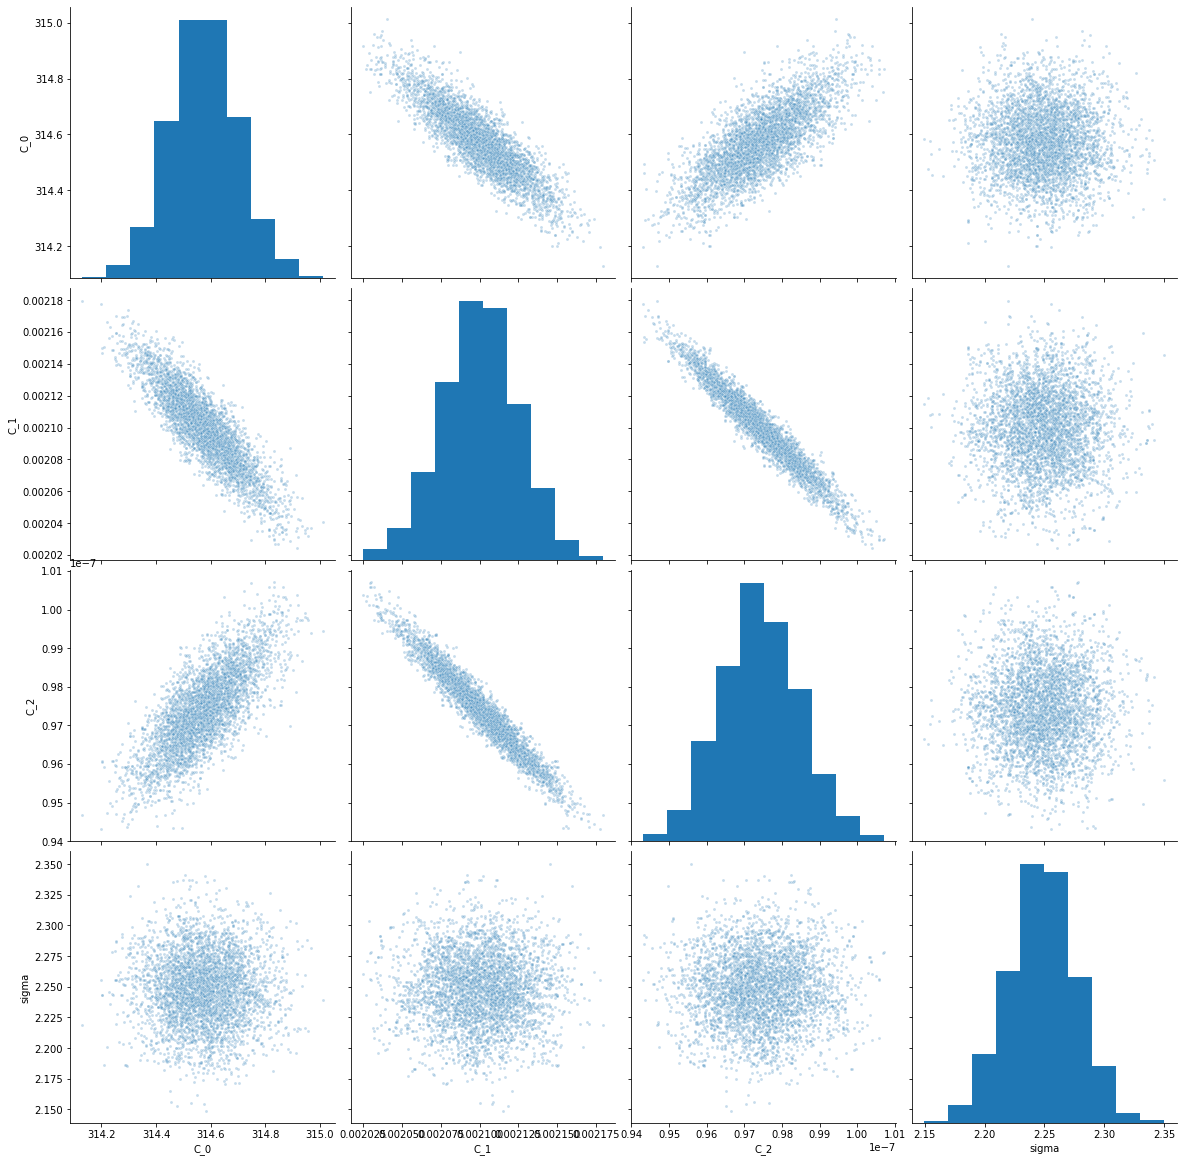

In [0]:
parameters_quad = ['C_0', 'C_1', 'C_2','sigma']
quad_samples = quad_results.extract()

df_quad = pd.DataFrame(
    data=np.transpose([quad_samples[param] for param in parameters_quad]),
    columns=parameters_quad)
seaborn.pairplot(df_quad, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

Model 2: $C_3 + C_4^{t*C_5}$

Where:

$C_3$ ~ $Normal(310,4)$

$C_4$ ~ $Normal(1,0.1)$

$C_5$ ~ $Beta(0.08,5)$


In [0]:
# The exponential model only converges after normalizing the data
df['Normalized'] =  df['Days'] / max(df['Days'])

stan_data_exp = {
    "n_data" : len(df),
    "time" : df['Normalized'],
    "ppms" : df['CO2 ppm'],
}

In [0]:
'''
Model 2
'''

exp_code = """
data {
    int<lower=0> n_data; // data size
    real<lower=0> time[n_data]; // normalized time
    real ppms[n_data]; // observed level of CO2 for each day
}

parameters {
    
    real<lower=0> C_3; // baseline constant
    real<lower=1> C_4; // exponential growth rate
    real<lower=0> C_5; // multiplying constant
    real<lower=0> sigma; // noise
}

model {
 
    // Priors
    C_3 ~ normal(310, 4);
    C_4 ~ normal(1.00006,0.1);
    C_5 ~ normal(0.08, 5);
    sigma ~ gamma(3, 0.5);
    
    // Likelihood
    for (i in 1:n_data) {
        ppms[i] ~ normal(C_3 + C_4^(time[i]*C_5), sigma); 
    }
}
"""

In [0]:
exp_model = pystan.StanModel(model_code=exp_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_360091883ca6bd92e7a9eff0781238f2 NOW.


In [0]:
exp_results = exp_model.sampling(data=stan_data_exp)
print(exp_results)

Inference for Stan model: anon_model_360091883ca6bd92e7a9eff0781238f2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C_3   333.47  4.2e-3   0.24 333.04 333.31 333.47 333.64 333.93   3188    1.0
C_4     1.32  1.6e-3   0.05   1.23   1.28   1.32   1.35   1.43    963   1.01
C_5    16.93    0.08   2.32  12.87  15.26  16.75  18.43  21.91    956   1.01
sigma   10.8  3.3e-3   0.13  10.54  10.71   10.8  10.88  11.07   1592    1.0
lp__   -9117    0.04   1.42  -9121  -9118  -9117  -9116  -9116   1220    1.0

Samples were drawn using NUTS at Fri Apr 24 05:08:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


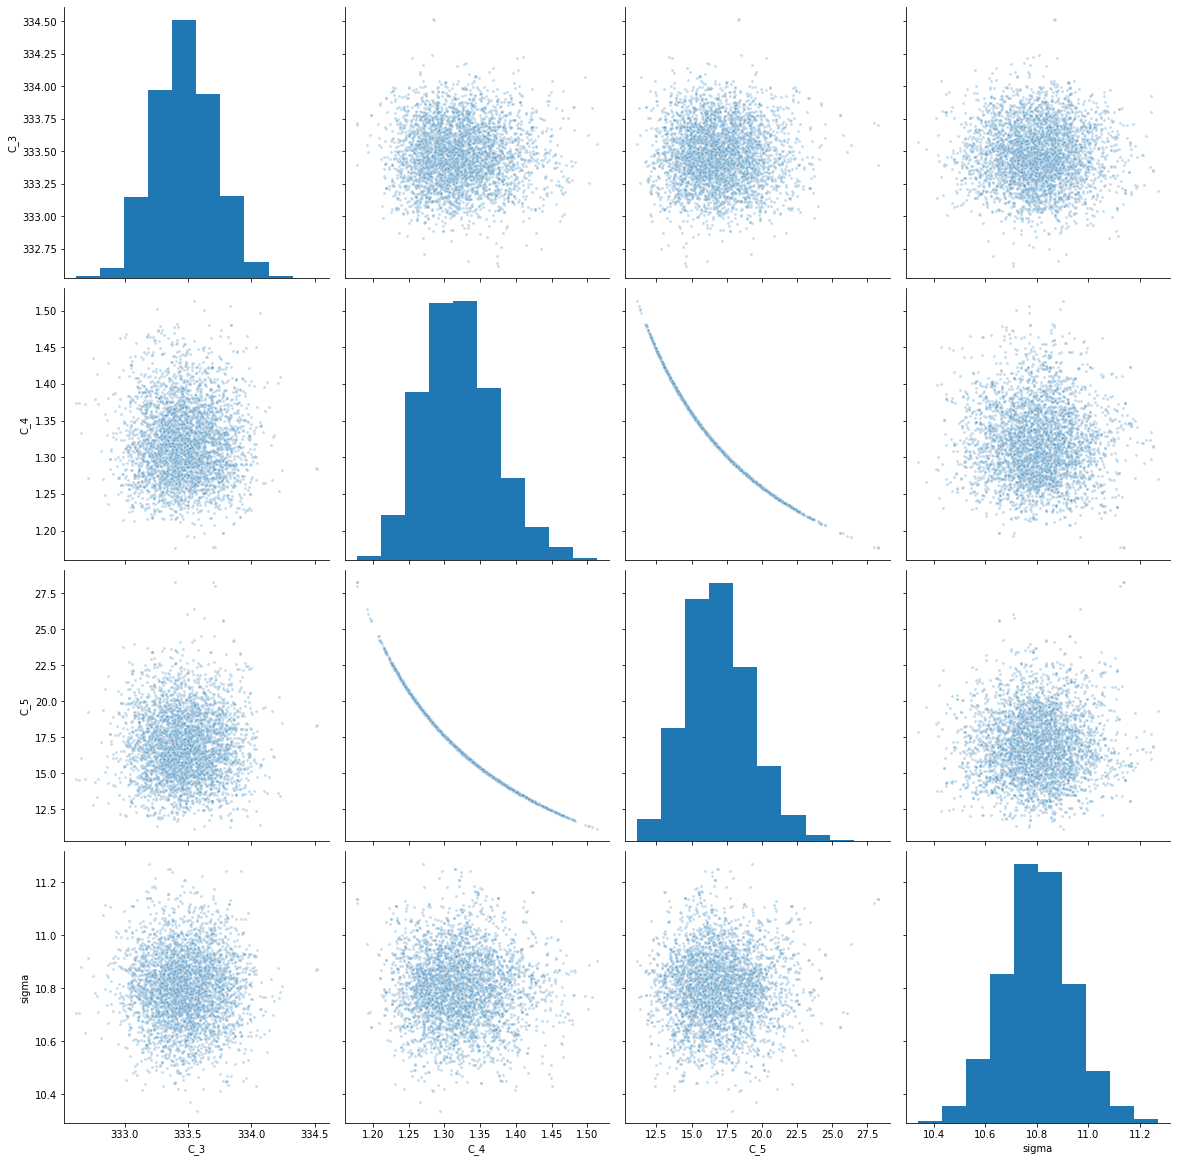

In [0]:
parameters_exp = ['C_3','C_4', 'C_5','sigma']
exp_samples = exp_results.extract()

df_exp = pd.DataFrame(
    data=np.transpose([exp_samples[param] for param in parameters_exp]),
    columns=parameters_exp)
seaborn.pairplot(df_exp, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

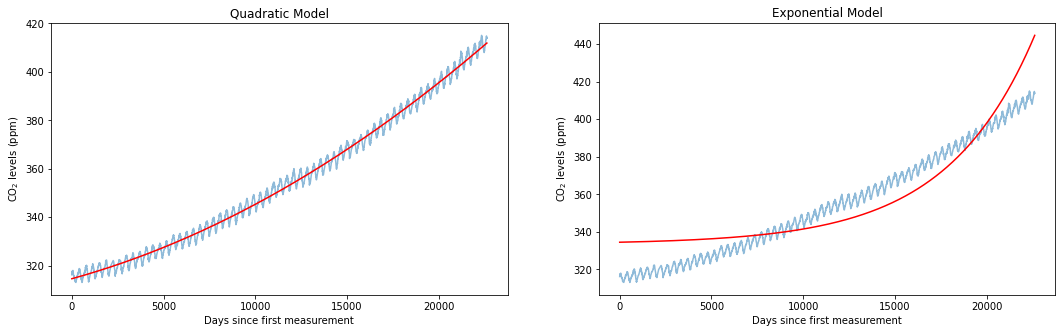

In [0]:
# Plotting the results
quad_approx = quad_samples['C_0'].mean() + quad_samples['C_1'].mean()*df['Days'] + quad_samples['C_2'].mean()*(df['Days']**2) 
exp_approx = exp_samples['C_3'].mean() + exp_samples['C_4'].mean()**(df['Normalized']*exp_samples['C_5'].mean())

plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
plt.plot(days, CO2, alpha=0.5)
plt.plot(days, quad_approx, color="red")
plt.title("Quadratic Model")
plt.xlabel("Days since first measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 2, 2)
plt.plot(days, CO2, alpha=0.5)
plt.plot(days, exp_approx, color="red")
plt.title("Exponential Model")
plt.xlabel("Days since first measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

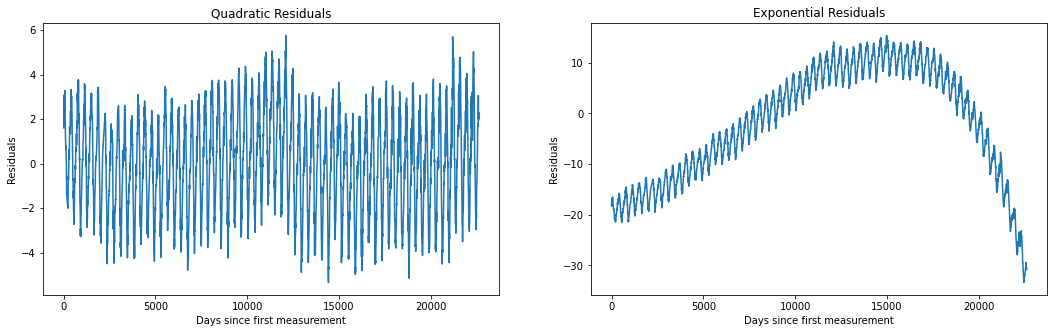

RMSE for the quadratic model: 2.2459623077622686
RMSE for the exponential model: 11.232850187687838


In [0]:
# Plotting residuals
quad_resid = CO2 - quad_approx
exp_resid = CO2 - exp_approx

plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
plt.plot(days, quad_resid)
plt.title("Quadratic Residuals")
plt.xlabel("Days since first measurement")
plt.ylabel(r'Residuals')
plt.subplot(1, 2, 2)
plt.plot(days, exp_resid)
plt.title("Exponential Residuals")
plt.xlabel("Days since first measurement")
plt.ylabel(r'Residuals')
plt.show()

# Calculating RMSE
quad_RMSE = np.sqrt((quad_resid**2).mean())
exp_RMSE =  np.sqrt((exp_resid**2).mean())

print('RMSE for the quadratic model: ' + str(quad_RMSE))
print('RMSE for the exponential model: ' + str(exp_RMSE))

## *Seasonal Variation*
Model 1: $ A_1*cos(\frac{2\pi}{365.25}t + \phi_1)$

Where:

$A_1$ ~ $Normal(6,4)$

$\phi_1$ ~ $Cauchy(0,\pi)$

In [0]:
df['Residuals'] = quad_resid

stan_data_seasonal = {
    "n_data" : len(df),
    "time" : df['Days'],
    "ppms" : df['CO2 ppm'],
}

In [0]:
'''
Model 1
'''

cos_code = """
data {
    int<lower=0> n_data; // data size
    real<lower=0> time[n_data]; // days from first measurement
    real ppms[n_data]; // observed level of CO2 for each day
}

parameters {
    real<lower=0> A_1; // amplitude
    real<lower=0, upper=pi()> phi; // phase
    real<lower=0> sigma; // noise
}


model {
 
    // Priors
    A_1 ~ normal(6, 4);
    phi ~ cauchy(0, pi());
    sigma ~ gamma(3, 0.5);
    
    // Likelihood
    for (i in 1:n_data) {
        ppms[i] ~ normal((A_1*cos(((2*pi()*time[i])/365.25)+phi)), sigma); 
    }
}

"""


In [0]:
cos_model = pystan.StanModel(model_code=cos_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_89a8c518fb6b0e92e51be8308cfebc97 NOW.


In [0]:
cos_results = cos_model.sampling(data=stan_data_seasonal)
print(cos_results)

Inference for Stan model: anon_model_89a8c518fb6b0e92e51be8308cfebc97.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A_1     5.59    0.07   3.13   0.55   3.12   5.35   7.72  12.38   2124    1.0
phi     1.41    0.02    0.9   0.06   0.63    1.3   2.16   3.04   3346    1.0
sigma 347.46    0.07   4.23 339.32 344.58 347.39 350.18 356.04   3239    1.0
lp__  -2.0e4    0.04   1.42 -2.0e4 -2.0e4 -2.0e4 -2.0e4 -2.0e4   1183    1.0

Samples were drawn using NUTS at Fri Apr 24 06:52:17 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


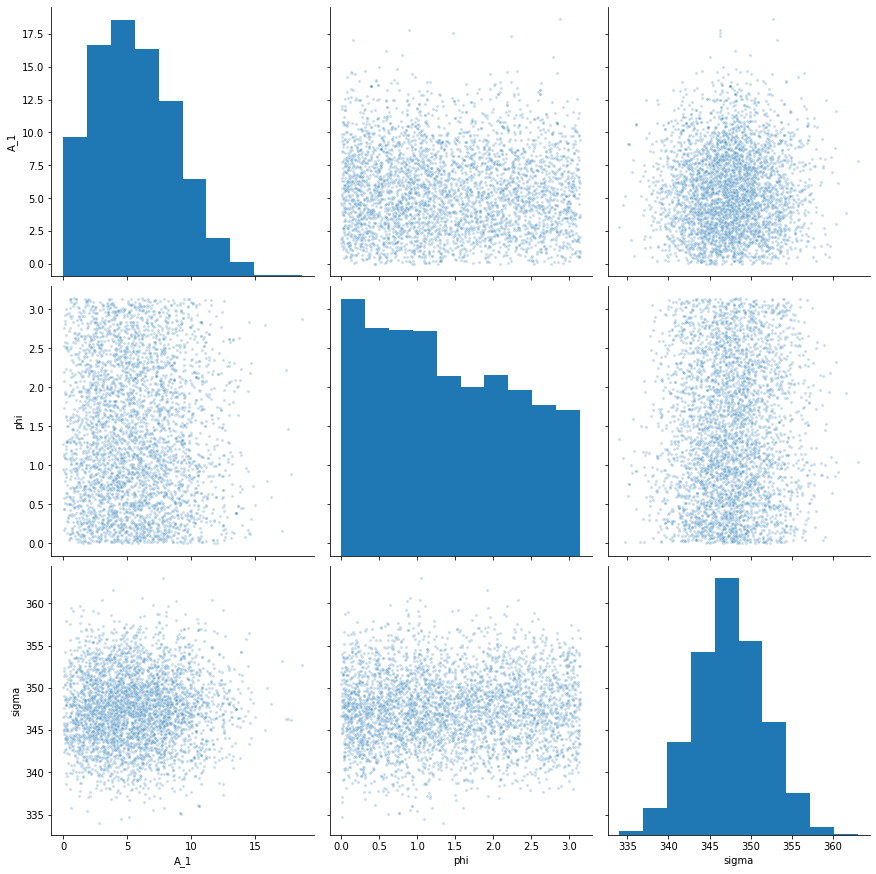

In [0]:
parameters_cos = ['A_1', 'phi', 'sigma']
cos_samples = cos_results.extract()

df_cos = pd.DataFrame(
    data=np.transpose([cos_samples[param] for param in parameters_cos]),
    columns=parameters_cos)
seaborn.pairplot(df_cos, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

Model 2: $(\frac{A_2 + g*10^{-4}t}{-z}) * tan^{-1}(\frac{-z*sin(\frac{2\pi}{365.25}t + \phi_2)}{1+z*cos(\frac{2\pi}{365.25}t + \phi_2)})$


Where:

$A_2$ ~ $Normal(4.5, 3.3)$

$\phi_2$ ~ $Cauchy(0,\pi)$

$g$ ~ $Normal(0.14,0.1)$

$z$ ~ $Beta(1.5,5)$

In [0]:
'''
Model 2
'''

asymm_code = """
data {
    int<lower=0> n_data; // data size
    real<lower=0> time[n_data]; // days from first measurement
    real ppms[n_data]; // observed level of CO2 for each day
}

parameters {
    real<lower=0> A_2; // amplitude
    real<lower=0, upper=pi()> phi; // phase
    real<lower=0> g; // growth rate
    real<lower=0, upper=1> z; // tilt parameter
    real<lower=0> sigma; // noise
}

model {
 
    // Priors
    A_2 ~ normal(4.5, 3.3);
    phi ~ cauchy(0, pi());
    g ~ normal(0.14, 0.01);
    z ~ beta(1.5, 5);
    sigma ~ gamma(3, 0.5);

    // Likelihood
    for (i in 1:n_data) {
        ppms[i] ~ normal(((A_2+time[i]*g*10^(-4))/(-1*z))*atan((-1*z*sin(((2*pi()*time[i])/365.25)+phi))/(1+z*cos(((2*pi()*time[i])/365.25)+phi))), sigma); 
    }
}

"""

In [0]:
asymm_model = pystan.StanModel(model_code=asymm_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7367acbcea6341b7dee8472f55a38801 NOW.


In [0]:
asymm_results = asymm_model.sampling(data=stan_data_seasonal)
print(asymm_results)

Inference for Stan model: anon_model_7367acbcea6341b7dee8472f55a38801.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A_2     4.59    0.05   2.59   0.43   2.62   4.36    6.3   10.1   3233    1.0
phi     1.36    0.01   0.88   0.07    0.6   1.27   2.06   3.02   4921    1.0
g       0.14  1.4e-4 9.7e-3   0.12   0.13   0.14   0.15   0.16   4637    1.0
z       0.23  2.2e-3   0.15   0.02   0.11    0.2   0.32   0.58   4580    1.0
sigma 347.43    0.06    4.3 339.15 344.64 347.34 350.15 356.35   4943    1.0
lp__  -2.0e4    0.05   1.75 -2.0e4 -2.0e4 -2.0e4 -2.0e4 -2.0e4   1414    1.0

Samples were drawn using NUTS at Fri Apr 24 06:56:46 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


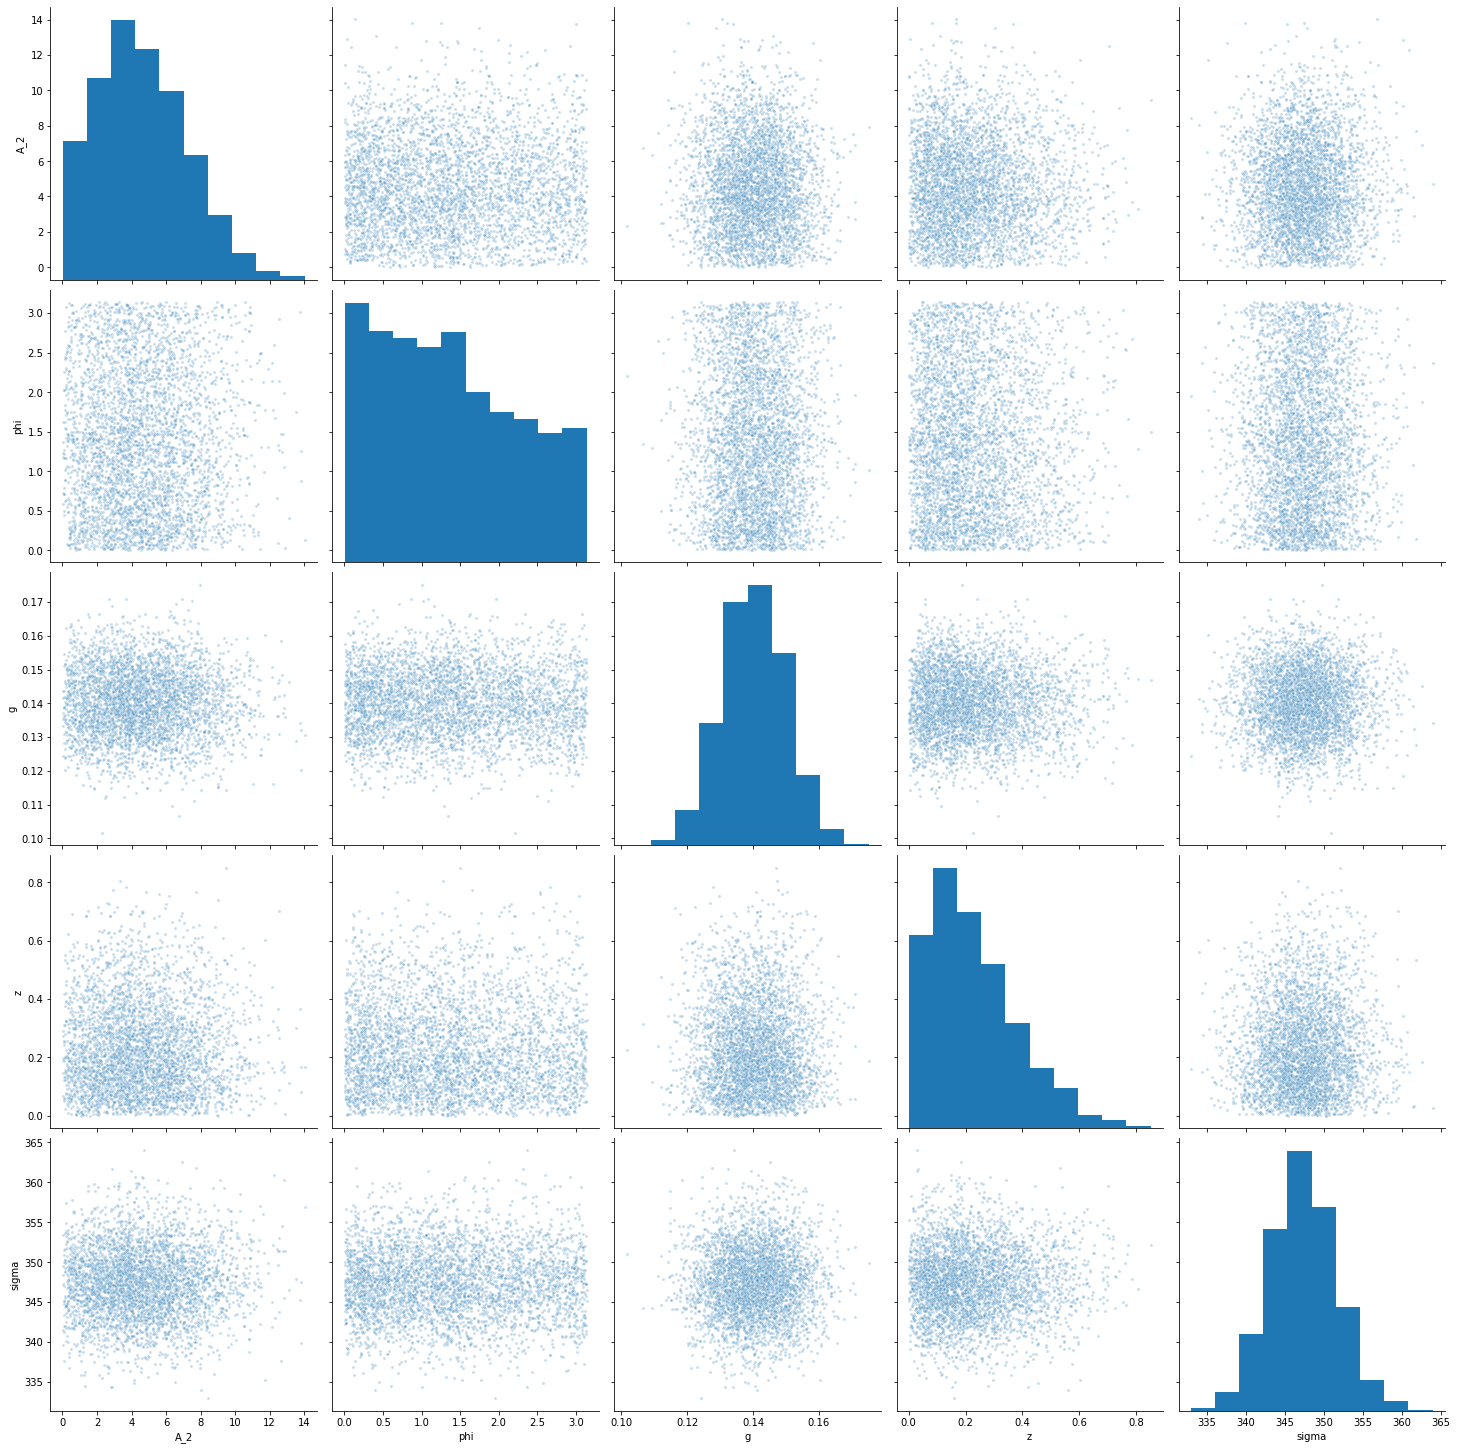

In [0]:
parameters_asymm = ['A_2', 'phi', 'g', 'z','sigma']
asymm_samples = asymm_results.extract()

df_asymm = pd.DataFrame(
    data=np.transpose([asymm_samples[param] for param in parameters_asymm]),
    columns=parameters_asymm)
seaborn.pairplot(df_asymm, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

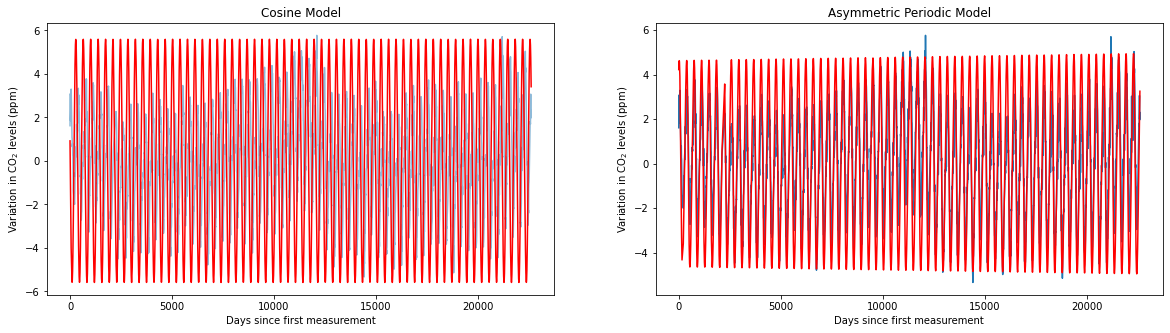

In [0]:
# Plotting the results
cos_approx = cos_samples['A_1'].mean()*np.cos(((2*np.pi*df['Days'])/365.25)+cos_samples['phi'].mean())
asymm_approx = ((asymm_samples['A_2'].mean()+df['Days']*asymm_samples['g'].mean()*10**(-4))/(-1*asymm_samples['z'].mean()))*np.arctan((-1*asymm_samples['z'].mean()*np.sin(((2*np.pi*df['Days'])/365.25)+asymm_samples['phi'].mean()))/(1+asymm_samples['z'].mean()*np.cos(((2*np.pi*df['Days'])/365.25)+asymm_samples['phi'].mean())))

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(days, df['Residuals'], alpha=0.5)
plt.plot(days, cos_approx, color="red")
plt.title("Cosine Model")
plt.xlabel("Days since first measurement")
plt.ylabel(r'Variation in CO$_2$ levels (ppm)')
plt.subplot(1, 2, 2)
plt.plot(days, df['Residuals'])
plt.plot(days, asymm_approx, color="red")
plt.title("Asymmetric Periodic Model")
plt.xlabel("Days since first measurement")
plt.ylabel(r'Variation in CO$_2$ levels (ppm)')
plt.show()

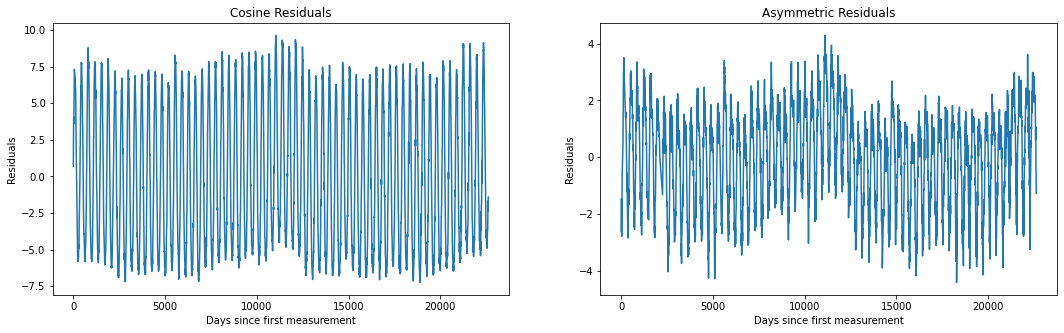

RMSE for the cosine model: 4.968771218098549
RMSE for the asymmetric model: 1.692757599983147


In [0]:
# Plotting residuals
cos_resid = df['Residuals'] - cos_approx
asymm_resid = df['Residuals'] - asymm_approx

plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
plt.plot(days, cos_resid)
plt.title("Cosine Residuals")
plt.xlabel("Days since first measurement")
plt.ylabel(r'Residuals')
plt.subplot(1, 2, 2)
plt.plot(days, asymm_resid)
plt.title("Asymmetric Residuals")
plt.xlabel("Days since first measurement")
plt.ylabel(r'Residuals')
plt.show()

# Calculating RMSE
cos_RMSE = np.sqrt((cos_resid**2).mean())
asymm_RMSE =  np.sqrt((asymm_resid**2).mean())

print('RMSE for the cosine model: ' + str(cos_RMSE))
print('RMSE for the asymmetric model: ' + str(asymm_RMSE))

# Model
The likelihood function for the average CO2 level at any day is a function of:

${CO_2} \sim \text{Normal}({\mu}, {\sigma})$,
where:

$\mu= (C_0 + C_1*t + C_2*t^2)+ (\frac{A_2 + g*10^{-4}t}{-z}) * tan^{-1}(\frac{-z*sin(\frac{2\pi}{365.25}t + \phi_2)}{1+z*cos(\frac{2\pi}{365.25}t + \phi_2)})$

$C_0$ ~ $Normal(310,4)$ 

$C_1$ ~ $Normal(0,0.1)$ 

$C_2$ ~ $Normal(0,0.1)$

$A_2$ ~ $Normal(4.5, 3.3)$

$\phi_2$ ~ $Cauchy(0,\pi)$

$g$ ~ $Normal(0.14,0.1)$

$z$ ~ $Beta(1.5,5)$

$\sigma$ ~ $Gamma(3,0.5)$

In [0]:
stan_data = {
    "n_data" : len(df),
    "time" : df['Days'],
    "ppms" : df['CO2 ppm'],
}

In [0]:
'''
Full Model
'''

stan_code = """
data {
    int<lower=0> n_data; // data size
    real<lower=0> time[n_data]; // days from first measurement
    real ppms[n_data]; // observed level of CO2 for each day
}

parameters {
    real<lower=0> C_0; // baseline constant for trend
    real<lower=0> C_1; // linear constant for trend
    real<lower=0> C_2; // quadratic constant for trend
    real<lower=0> A_2; // amplitude for seasonality
    real<lower=0, upper=pi()> phi; // phase for seasonality
    real<lower=0> g; // growth rate for seasonality
    real<lower=0, upper=1> z; // tilt parameter for seasonality
    real<lower=0> sigma; // noise
}


model {
 
    // Priors
    C_0 ~ normal(310, 4);
    C_1 ~ normal(0, 0.1);
    C_2 ~ normal(0, 0.1);
    A_2 ~ normal(4.5, 3.3);
    phi ~ cauchy(0, pi());
    g ~ normal(0.14, 0.01);
    z ~ beta(1.5, 5);
    sigma ~ gamma(3, 0.5);

    // Likelihood
    for (i in 1:n_data) {
        ppms[i] ~ normal((C_0+C_1*time[i]+C_2*time[i]^2)+(((A_2+time[i]*g*10^(-4))/(-1*z))*atan((-1*z*sin(((2*pi()*time[i])/365.25)+phi))/(1+z*cos(((2*pi()*time[i])/365.25)+phi)))), sigma); 
    }
}

"""

In [8]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1dec2ec8487a7d126f2393827645ab79 NOW.


In [9]:
stan_results = stan_model.sampling(data=stan_data)
print(stan_results)

Inference for Stan model: anon_model_1dec2ec8487a7d126f2393827645ab79.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C_0   314.59  7.9e-4    0.05  314.5 314.56 314.59 314.62 314.68   3502    1.0
C_1   2.1e-3  1.6e-7  9.5e-6 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   3308    1.0
C_2   9.8e-8 7.1e-12 4.0e-10 9.7e-8 9.7e-8 9.8e-8 9.8e-8 9.8e-8   3210    1.0
A_2      2.7  4.3e-4    0.02   2.66   2.69    2.7   2.72   2.75   3071    1.0
phi     1.13  1.0e-4  6.8e-3   1.12   1.13   1.13   1.14   1.14   4570    1.0
g       0.15  1.7e-4  9.4e-3   0.13   0.14   0.15   0.15   0.17   3209    1.0
z       0.42  2.0e-4    0.01    0.4   0.42   0.42   0.43   0.45   3329    1.0
sigma   0.85  1.6e-4    0.01   0.83   0.84   0.84   0.85   0.87   4203    1.0
lp__   -1072    0.05    1.95  -1077  -1073  -1072  -1070  -1069   1788    1.0

Samples were drawn using NUTS 

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


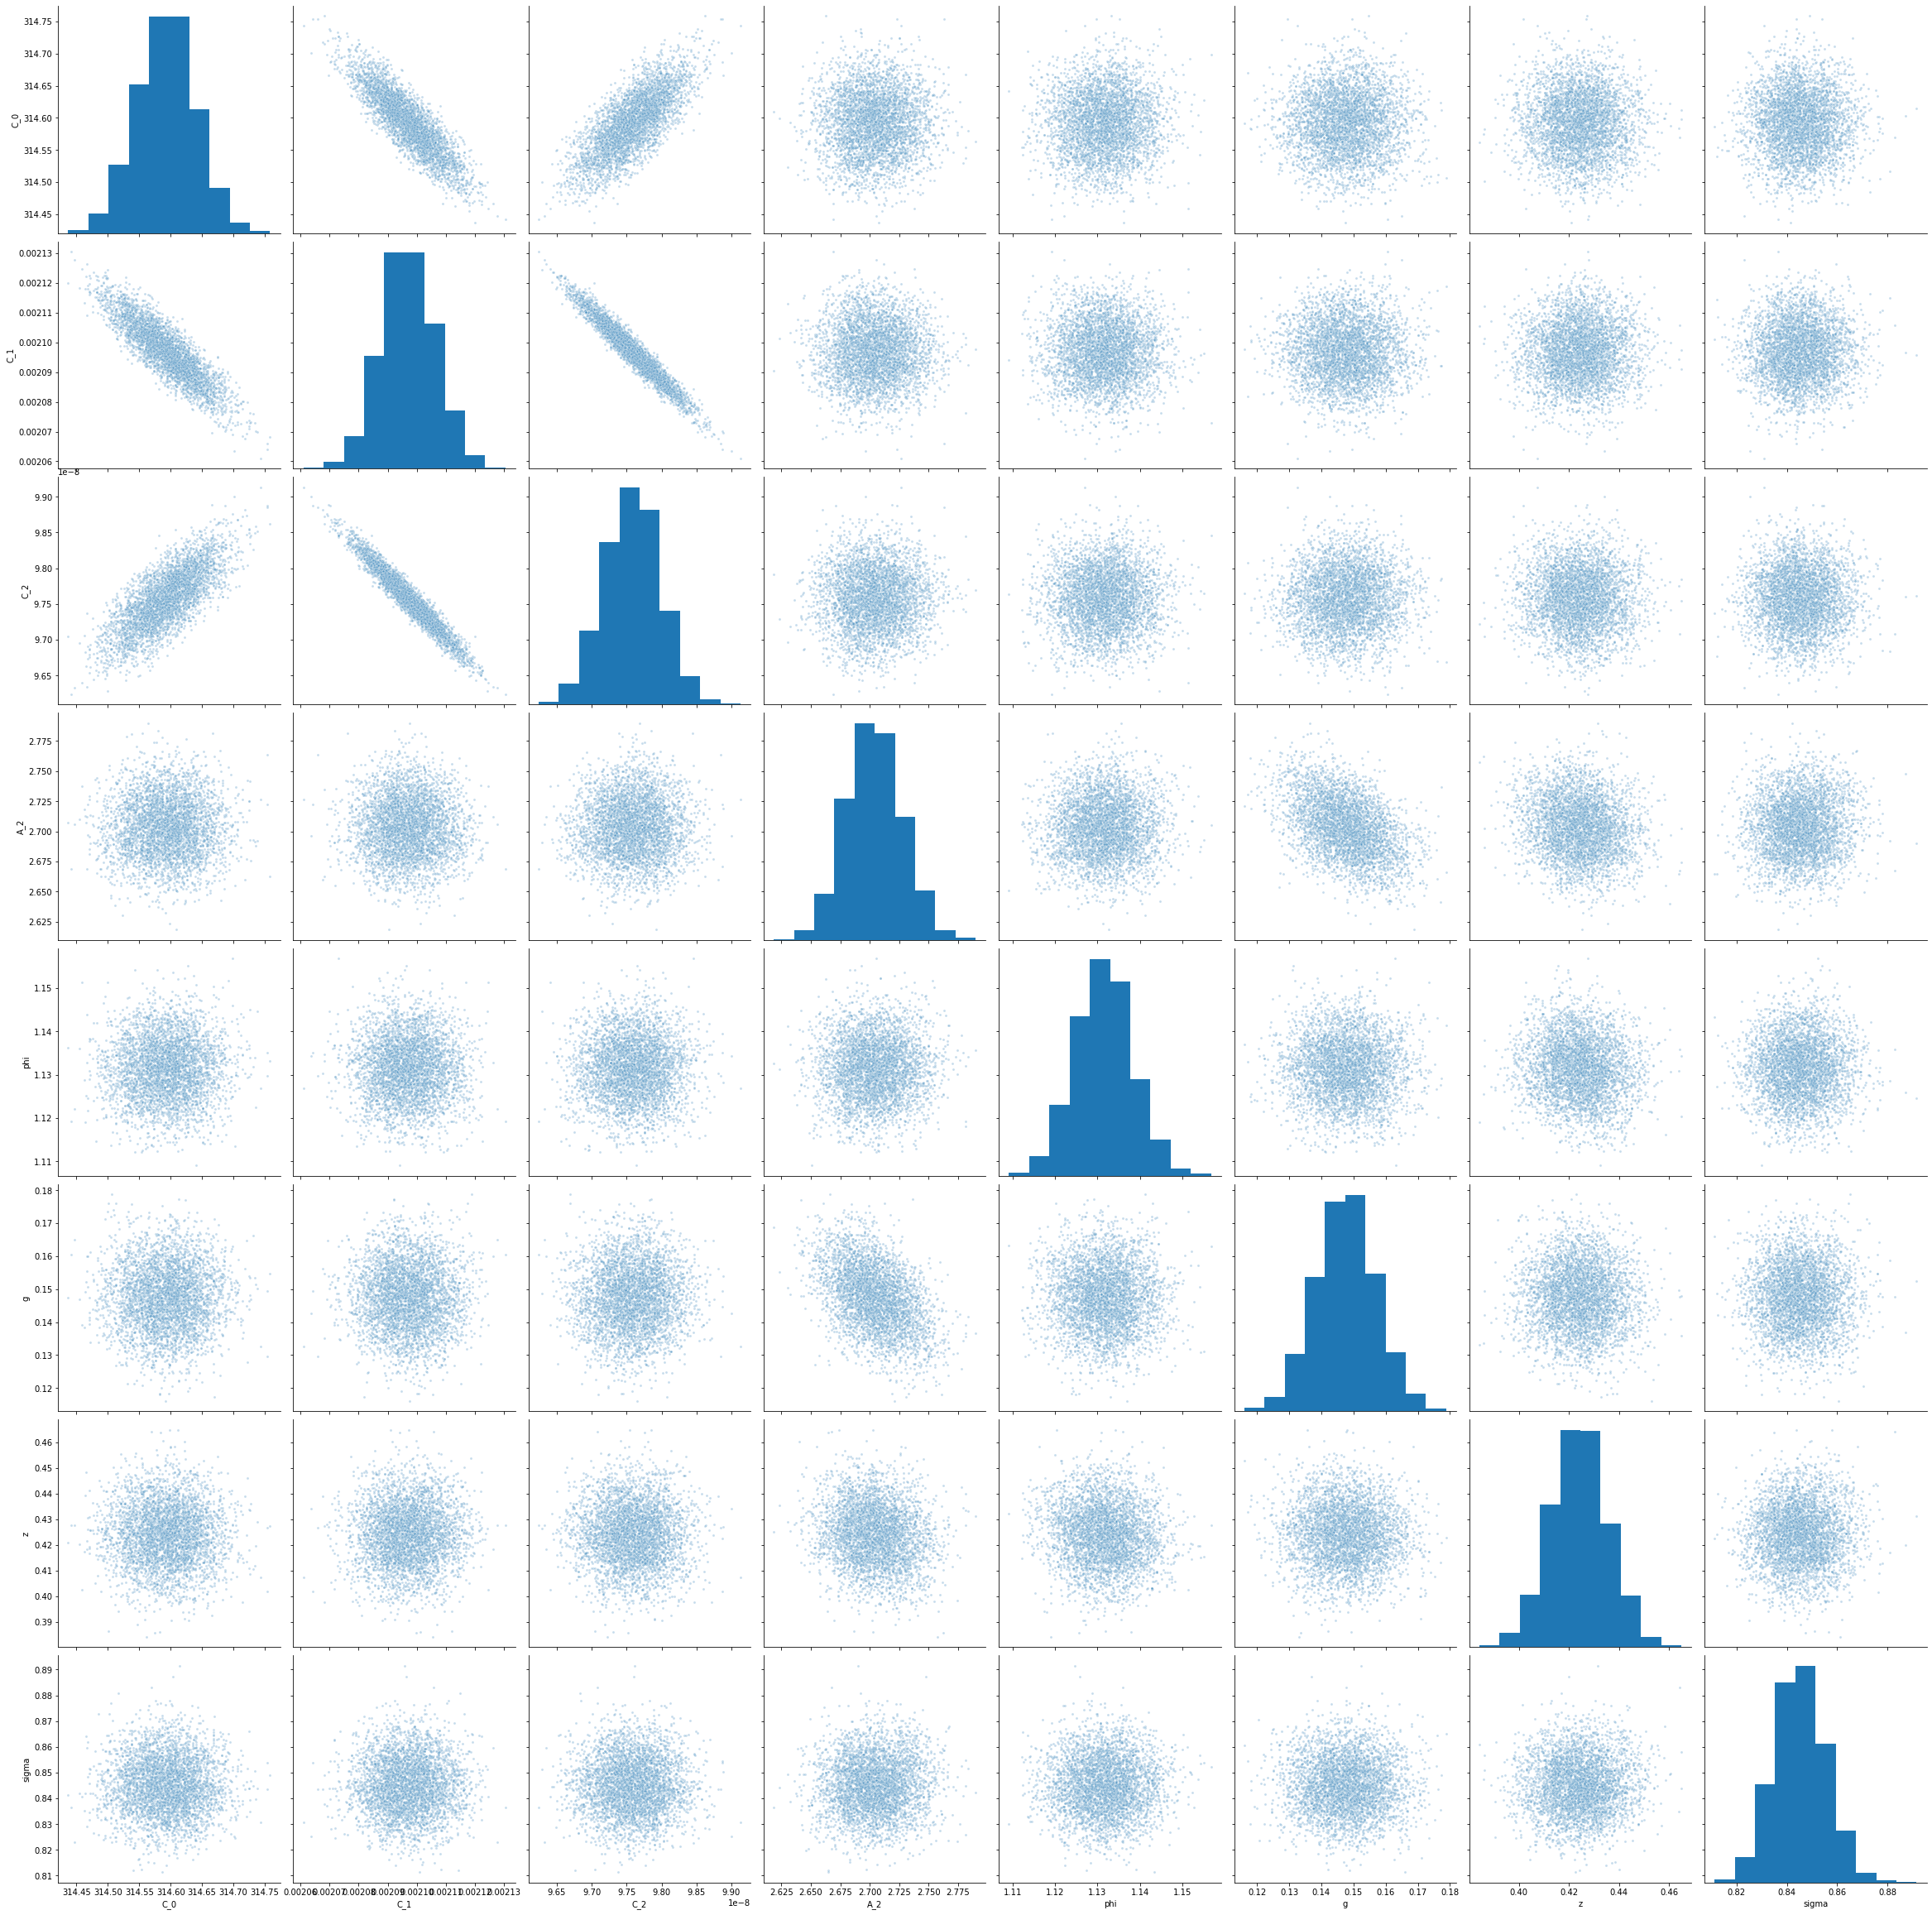

In [11]:
parameters = ['C_0', 'C_1', 'C_2', 'A_2', 'phi', 'g', 'z','sigma']
stan_samples = stan_results.extract()

df_stan = pd.DataFrame(
    data=np.transpose([stan_samples[param] for param in parameters]),
    columns=parameters)
pair_plot1 = seaborn.pairplot(df_stan, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()
pair_plot1.savefig("pair_plot1.png")

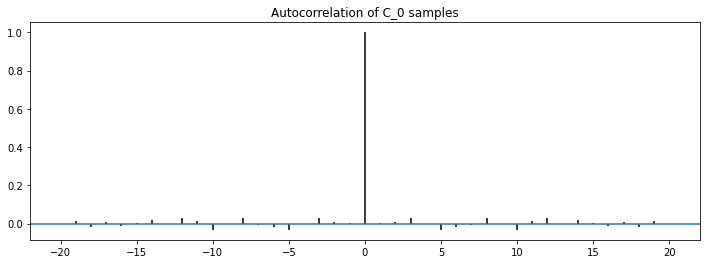

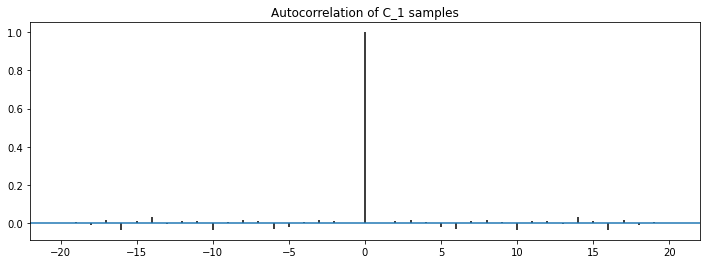

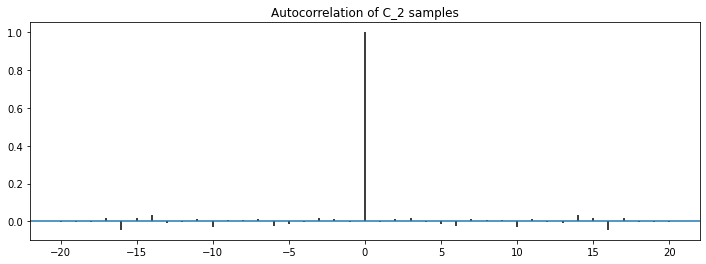

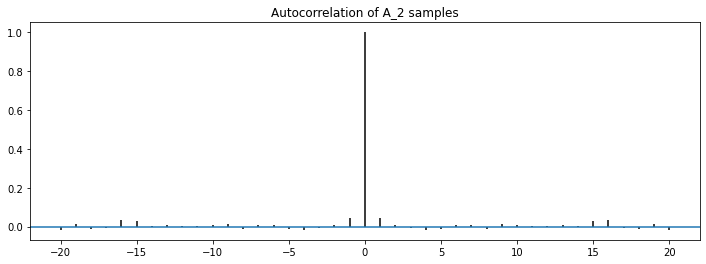

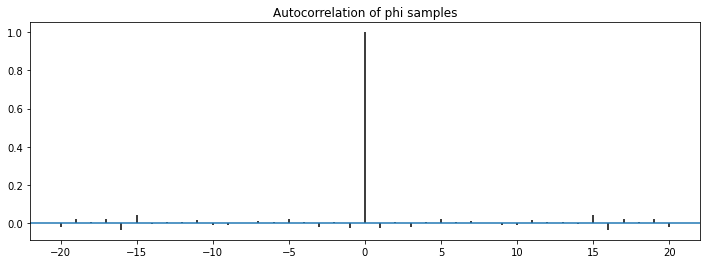

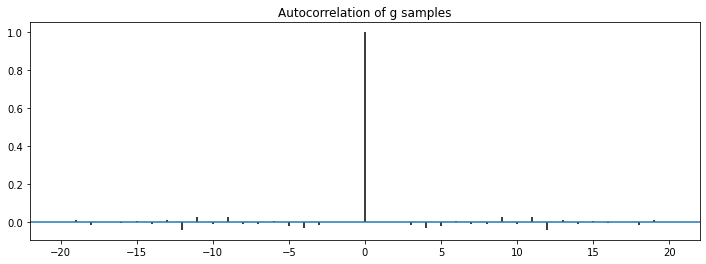

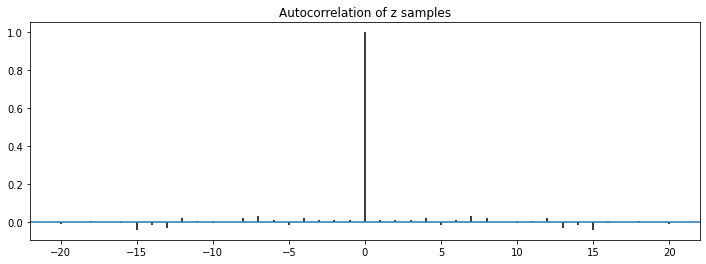

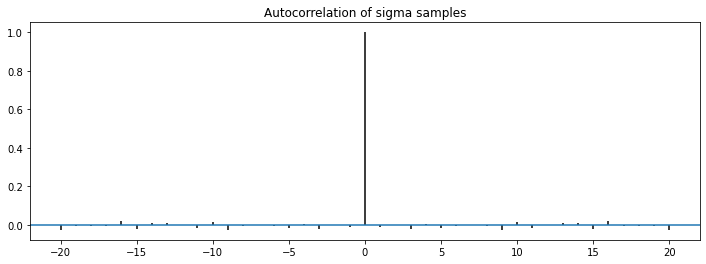

In [12]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(stan_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

# Posterior Predictive Checks

In [0]:
# Sampling posterior parameters
n_sample = 10000

sample_C0 = np.random.choice(stan_samples['C_0'], size= n_sample) # sample C_0 from the posterior distribution
sample_C1 = np.random.choice(stan_samples['C_1'], size= n_sample) # sample C_1 from the posterior distribution
sample_C2 = np.random.choice(stan_samples['C_2'], size= n_sample) # sample C_2 from the posterior distribution
sample_A2 = np.random.choice(stan_samples['A_2'], size= n_sample) # sample A_2 from the posterior distribution
sample_g = np.random.choice(stan_samples['g'], size= n_sample) # sample g from the posterior distribution
sample_z = np.random.choice(stan_samples['z'], size= n_sample) # sample z from the posterior distribution
sample_phi = np.random.choice(stan_samples['phi'], size= n_sample) # sample phi from the posterior distribution
sample_sigma = np.random.choice(stan_samples['sigma'], size= n_sample) # sample sigma from the posterior distribution

In [0]:
# Creating a dataframe to put the replicated data in
replicated_df = np.zeros((n_sample,len(df))) 

for i in range(0, n_sample):
  replicated_df[i,:] = sts.norm.rvs(sample_C0[i] + sample_C1[i] *df['Days'] + sample_C2[i] *(df['Days']**2) + ((sample_A2[i] +df['Days']*sample_g[i] *10**(-4))/(-1*sample_z[i] ))*np.arctan((-1*sample_z[i] *np.sin(((2*np.pi*df['Days'])/365.25)+sample_phi[i]))/(1+sample_z[i] *np.cos(((2*np.pi*df['Days'])/365.25)+sample_phi[i]))), sample_sigma[i])

In [0]:
# Defining test statistics
replicated_mean = np.mean(replicated_df, axis=1)
real_mean = np.mean(CO2)

replicated_stdev = np.std(replicated_df, axis=1)
real_stdev = np.std(CO2)

replicated_min = np.amin(replicated_df, axis=1)
real_min = np.amin(CO2)

replicated_max = np.amax(replicated_df, axis=1)
real_max = np.amax(CO2)

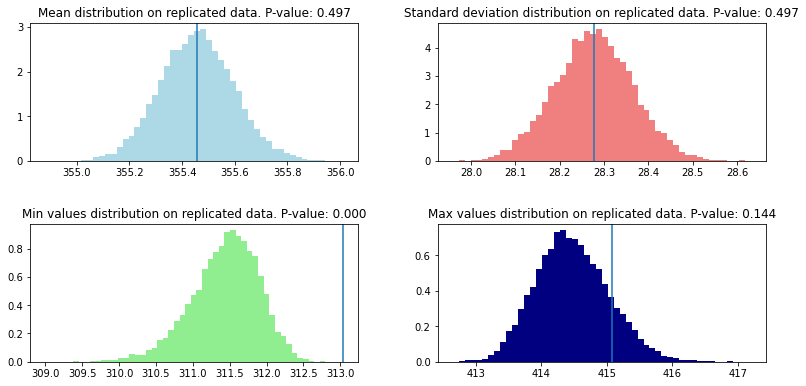

In [26]:
# Plotting test statiscits
predictive_posterior_checks = plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(replicated_mean, bins = 50, density=True, color='lightblue')
plt.axvline(real_mean)
plt.title('Mean distribution on replicated data. P-value: %.3f' % (
    np.mean(np.array(replicated_mean) > real_mean)))
plt.subplot(2, 2, 2)
plt.hist(replicated_stdev, bins = 50, density=True, color='lightcoral')
plt.axvline(real_stdev)
plt.title('Standard deviation distribution on replicated data. P-value: %.3f' % (
    np.mean(np.array(replicated_stdev) > real_stdev)))
plt.subplot(2, 2, 3)
plt.hist(replicated_min, bins = 50, density=True, color='lightgreen')
plt.axvline(real_min)
plt.title('Min values distribution on replicated data. P-value: %.3f' % (
    np.mean(np.array(replicated_min) > real_min)))
plt.subplot(2, 2, 4)
plt.hist(replicated_max, bins = 50, density=True, color='navy')
plt.axvline(real_max)
plt.title('Max values distribution on replicated data. P-value: %.3f' % (
    np.mean(np.array(replicated_max) > real_max)))
predictive_posterior_checks.tight_layout(pad=3.0)
plt.show()
predictive_posterior_checks.savefig("predictive_posterior_checks.png")

# Predictions

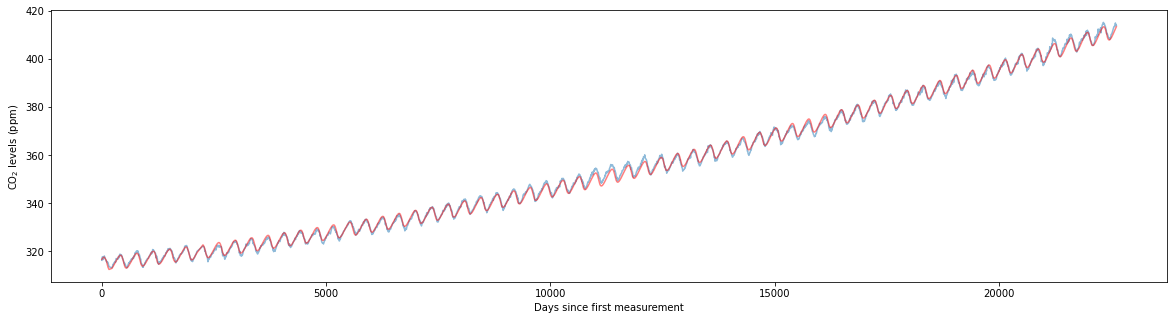

In [27]:
# Approximating the model
model_approx = stan_samples['C_0'].mean() + stan_samples['C_1'].mean()*df['Days'] + stan_samples['C_2'].mean()*(df['Days']**2) + ((stan_samples['A_2'].mean()+df['Days']*stan_samples['g'].mean()*10**(-4))/(-1*stan_samples['z'].mean()))*np.arctan((-1*stan_samples['z'].mean()*np.sin(((2*np.pi*df['Days'])/365.25)+stan_samples['phi'].mean()))/(1+stan_samples['z'].mean()*np.cos(((2*np.pi*df['Days'])/365.25)+stan_samples['phi'].mean())))

model_full = plt.figure(figsize=(20,5))
plt.plot(days, CO2, alpha = 0.5)
plt.plot(days, model_approx, color="red", alpha = 0.5)
plt.xlabel("Days since first measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()
model_full.savefig('model_full.png')

In [52]:
# Extending the analysis to predict future values
prediction = pd.DataFrame(data=pd.date_range(start='03/07/2020', end ='03/06/2060', freq='7D'), columns = ['Future Date'])
prediction_dates = prediction['Future Date']

# Transforming the date into number of days since the last measurement observed
prediction_days_present = []
for i in range(len(prediction_dates)):
  time_elapsed = prediction_dates[i]-prediction_dates[0]
  prediction_days_present.append(time_elapsed.days)

# Transforming into numbers of days from the first measurement observed
prediction_days = [prediction_days_present[i] + 22617 for i in range(len(prediction_days_present))]
prediction['Days from Present'] = prediction_days

print(prediction_days)
print(prediction_days_present)
print(prediction)

[22617, 22624, 22631, 22638, 22645, 22652, 22659, 22666, 22673, 22680, 22687, 22694, 22701, 22708, 22715, 22722, 22729, 22736, 22743, 22750, 22757, 22764, 22771, 22778, 22785, 22792, 22799, 22806, 22813, 22820, 22827, 22834, 22841, 22848, 22855, 22862, 22869, 22876, 22883, 22890, 22897, 22904, 22911, 22918, 22925, 22932, 22939, 22946, 22953, 22960, 22967, 22974, 22981, 22988, 22995, 23002, 23009, 23016, 23023, 23030, 23037, 23044, 23051, 23058, 23065, 23072, 23079, 23086, 23093, 23100, 23107, 23114, 23121, 23128, 23135, 23142, 23149, 23156, 23163, 23170, 23177, 23184, 23191, 23198, 23205, 23212, 23219, 23226, 23233, 23240, 23247, 23254, 23261, 23268, 23275, 23282, 23289, 23296, 23303, 23310, 23317, 23324, 23331, 23338, 23345, 23352, 23359, 23366, 23373, 23380, 23387, 23394, 23401, 23408, 23415, 23422, 23429, 23436, 23443, 23450, 23457, 23464, 23471, 23478, 23485, 23492, 23499, 23506, 23513, 23520, 23527, 23534, 23541, 23548, 23555, 23562, 23569, 23576, 23583, 23590, 23597, 23604, 23611

In [0]:
# Extending the analysis to predict future values
# Calculating means and 95% confidence interval

prediction_values_mean = np.array(stan_samples['C_0'].mean() + stan_samples['C_1'].mean()*prediction['Days from Present'] + stan_samples['C_2'].mean()*(prediction['Days from Present']**2) + ((stan_samples['A_2'].mean()+prediction['Days from Present']*stan_samples['g'].mean()*10**(-4))/(-1*stan_samples['z'].mean()))*np.arctan((-1*stan_samples['z'].mean()*np.sin(((2*np.pi*prediction['Days from Present'])/365.25)+stan_samples['phi'].mean()))/(1+stan_samples['z'].mean()*np.cos(((2*np.pi*prediction['Days from Present'])/365.25)+stan_samples['phi'].mean()))))
prediction_values_lower = np.array(np.percentile(stan_samples['C_0'],2.5) + np.percentile(stan_samples['C_1'],2.5)*prediction['Days from Present'] + np.percentile(stan_samples['C_2'],2.5)*(prediction['Days from Present']**2) + ((np.percentile(stan_samples['A_2'],2.5)+prediction['Days from Present']*np.percentile(stan_samples['g'],2.5)*10**(-4))/(-1*np.percentile(stan_samples['z'],2.5)))*np.arctan((-1*np.percentile(stan_samples['z'],2.5)*np.sin(((2*np.pi*prediction['Days from Present'])/365.25)+np.percentile(stan_samples['phi'],2.5)))/(1+np.percentile(stan_samples['z'],2.5)*np.cos(((2*np.pi*prediction['Days from Present'])/365.25)+np.percentile(stan_samples['phi'],2.5)))))
prediction_values_higher = np.array(np.percentile(stan_samples['C_0'],97.5) + np.percentile(stan_samples['C_1'],97.5)*prediction['Days from Present'] + np.percentile(stan_samples['C_2'],97.5)*(prediction['Days from Present']**2) + ((np.percentile(stan_samples['A_2'],97.5)+prediction['Days from Present']*np.percentile(stan_samples['g'],97.5)*10**(-4))/(-1*np.percentile(stan_samples['z'],97.5)))*np.arctan((-1*np.percentile(stan_samples['z'],97.5)*np.sin(((2*np.pi*prediction['Days from Present'])/365.25)+np.percentile(stan_samples['phi'],97.5)))/(1+np.percentile(stan_samples['z'],97.5)*np.cos(((2*np.pi*prediction['Days from Present'])/365.25)+np.percentile(stan_samples['phi'],97.5)))))

prediction['Mean Values'] = prediction_values_mean
prediction['Lower Values'] = prediction_values_lower
prediction['Higher Values'] = prediction_values_higher

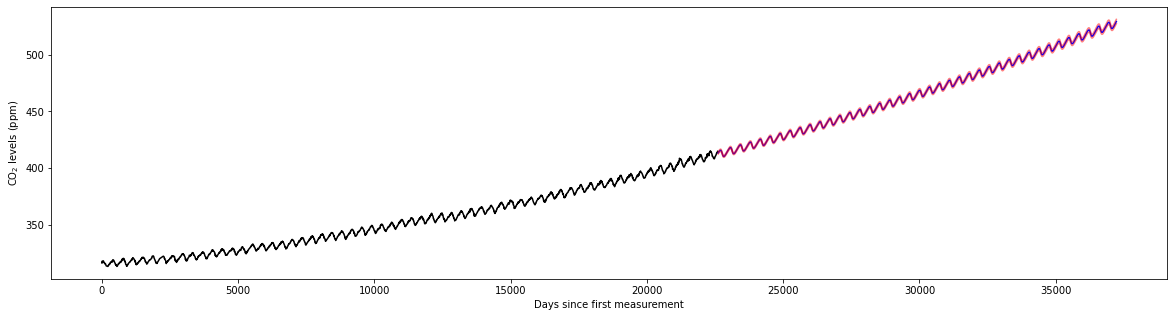

In [70]:
# Plotting all days (observed and predicted)
model_predicted = plt.figure(figsize=(20,5))
plt.plot(days, CO2, color = "black")
plt.plot(prediction_days, prediction_values_mean, color = "blue")
plt.plot(prediction_days, prediction_values_lower, color="red", alpha = 0.5)
plt.plot(prediction_days, prediction_values_higher, color="red", alpha = 0.5)
plt.xlabel("Days since first measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()
model_predicted.savefig('model_predicted.png')

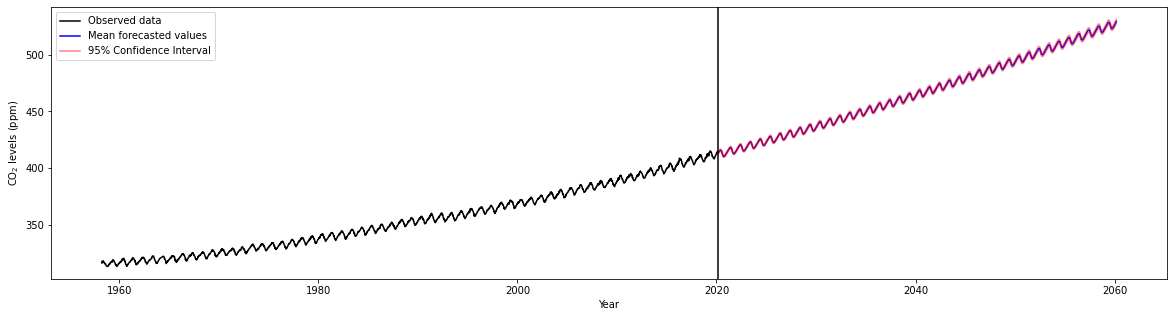

In [89]:
# Plotting all years (observed and predicted)
model_predicted_year = plt.figure(figsize=(20,5))
plt.plot(date, CO2, color = "black", label = 'Observed data')
plt.plot(prediction_dates, prediction_values_mean, color = "blue", label = 'Mean forecasted values')
plt.plot(prediction_dates, prediction_values_lower, color="red", alpha = 0.5, label = '95% Confidence Interval')
plt.plot(prediction_dates, prediction_values_higher, color="red", alpha = 0.5)
plt.axvline(date.iloc[-1], color='black')
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.legend()
plt.show()
model_predicted_year.savefig('model_predicted_year.png')

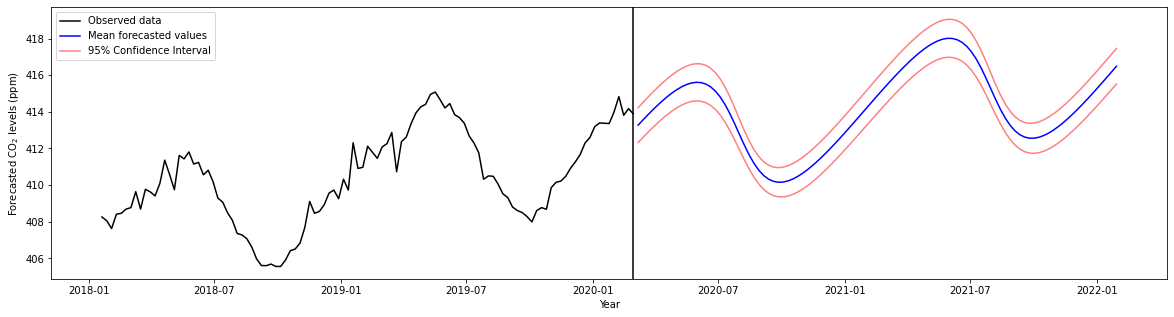

In [88]:
# Zooming in on 2020
model_predicted_2020 = plt.figure(figsize=(20,5))
plt.plot(date[3050:], CO2[3050:], color = "black", label = 'Observed data')
plt.plot(prediction_dates[:100], prediction_values_mean[:100], color = "blue", label = 'Mean forecasted values')
plt.plot(prediction_dates[:100], prediction_values_lower[:100], color="red", alpha = 0.5, label = '95% Confidence Interval')
plt.plot(prediction_dates[:100], prediction_values_higher[:100], color="red", alpha = 0.5)
plt.xlabel("Year")
plt.ylabel(r'Forecasted CO$_2$ levels (ppm)')
plt.axvline(date.iloc[-1], color='black')
plt.legend()
plt.show()
model_predicted_2020.savefig('model_predicted_2020.png')

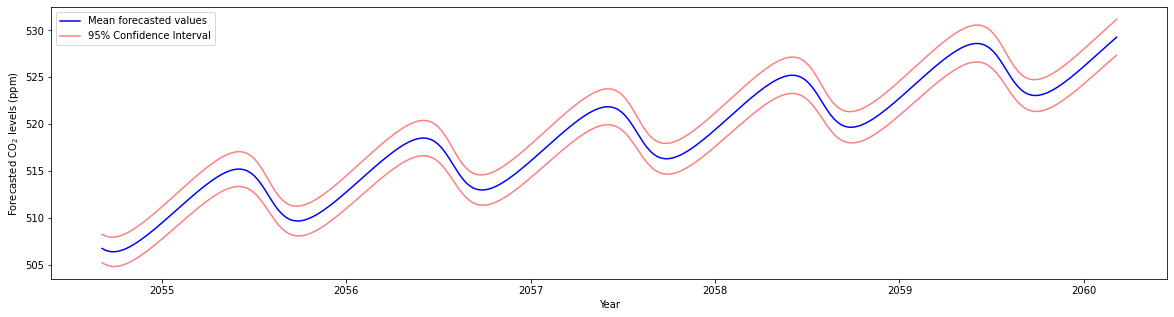

In [75]:
# Zooming in on 2060
model_predicted_2060 = plt.figure(figsize=(20,5))
plt.plot(prediction_dates[1800:], prediction_values_mean[1800:], color = "blue", label = 'Mean forecasted values')
plt.plot(prediction_dates[1800:], prediction_values_lower[1800:], color="red", alpha = 0.5, label = '95% Confidence Interval')
plt.plot(prediction_dates[1800:], prediction_values_higher[1800:], color="red", alpha = 0.5)
plt.xlabel("Year")
plt.ylabel(r'Forecasted CO$_2$ levels (ppm)')
plt.legend()
plt.show()
model_predicted_2060.savefig('model_predicted_2060.png')

In [102]:
# Prediction for 2060
higher_2060 = prediction_values_higher[2087,]
mean_2060 = prediction_values_mean[2087,]
lower_2060 = prediction_values_lower[2087,]

print("In March 2060, the CO2 emission level should be between",(lower_2060),"and",(higher_2060),", with a forecasted mean of",(mean_2060))

In March 2060, the CO2 emission level should be between 527.3573643849294 and 531.186380419104 , with a forecasted mean of 529.2755876875644


In [94]:
# Prediction for 2060
higher_2060 = prediction_values_higher[2087,]
mean_2060 = prediction_values_mean[2087,]
lower_2060 = prediction_values_lower[2087,]

print("In March 2060, the CO2 emission level should be between",(lower_2060),"and",(higher_2060),", with a forecasted mean of",(mean_2060))

531.186380419104


In [107]:
# When will we hit 450 ppm?

print(prediction_dates[np.min(np.argwhere(prediction_values_higher > 450))])
print(prediction_dates[np.min(np.argwhere(prediction_values_mean > 450))])
print(prediction_dates[np.min(np.argwhere(prediction_values_lower > 450))])

2033-05-21 00:00:00
2034-04-01 00:00:00
2034-05-13 00:00:00
